In [87]:
# Models
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Mahine Learning Tools
from pmdarima import auto_arima
from sklearn.metrics import  mean_squared_error 

# Data Manipulation Tools
import pandas as pd
import numpy as np

# Data Visualization Tools
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing Tools
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings(action='ignore')

In [88]:
# Import the Dataset
priceData = pd.read_csv("./data/processed/pricesList.csv")
rainfallData = pd.read_csv("./data/processed/rainfallData.csv")

In [89]:
# set the index to the date
def extractDate(data):
    data2 = data.copy()
    data2["Datetime"] = pd.to_datetime(data2[['Year', 'Month']].assign(day=(data2["Week"]-1)*7 +1))
    data2 = data2.set_index('Datetime')
    return data2
priceData = extractDate(priceData)

## Visualize Dataset

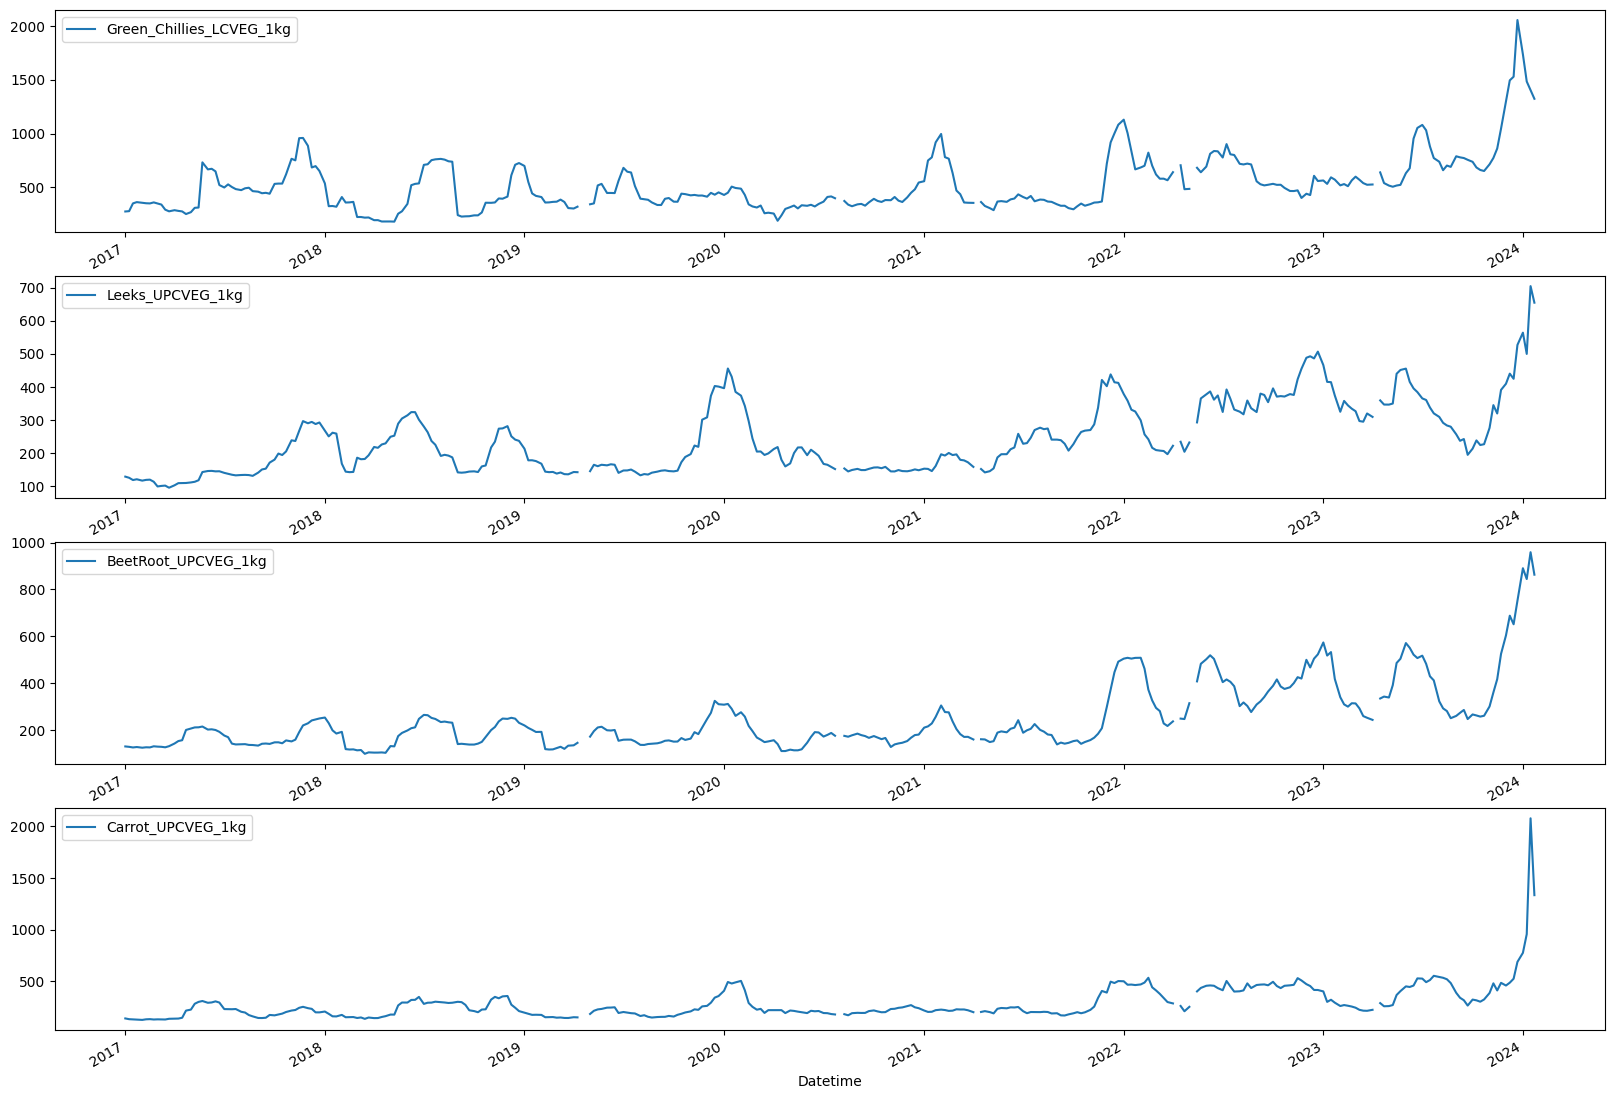

In [90]:
# Get all the unique values of the Name column in the dataset and iterate through them to display the price trend
uniqueNames = priceData['Name'].unique()
# fig with subplots for each name
fig, axs = plt.subplots(len(uniqueNames), 1, figsize=(20, 15))
for i, name in enumerate(uniqueNames):
    # filter the dataset to get the data for the current name
    priceData[priceData['Name'] == name]["Price"].plot(ax=axs[i], label=name)
    axs[i].legend(loc='upper left')
plt.show()

## Extract Data

In [91]:
# create a new dataset for processing
df = priceData.copy()
# extract only one vegetable for the prediction
vegetable = uniqueNames[1]
df = df[df["Name"] == vegetable]

In [92]:
# merge the rainfall data with the price data
for index, row in rainfallData.iterrows():
    year = row['year']
    month = row['month']
    df.loc[(df['Year'] == year) & (df['Month'] == month), 'anuradhapura'] = row['anuradhapura']
    df.loc[(df['Year'] == year) & (df['Month'] == month), 'jaffna'] = row['jaffna']
    df.loc[(df['Year'] == year) & (df['Month'] == month), 'nuwaraeliya'] = row['nuwaraeliya']


## Simple Imputer

In [93]:
# Simple Imputer for missing values in the dataset
def imputeData(data, column):
    imputer = SimpleImputer(missing_values = pd.NA, strategy ='mean')
    imputer.fit(data[[column]])
    # round to 2 decimal places
    data[column] = imputer.transform(data[[column]])
    data[column] = data[column].round(2)

imputeData(df, "Price")
imputeData(df, "anuradhapura")
imputeData(df, "jaffna")
imputeData(df, "nuwaraeliya")

# drop the columns where price is null
# df = df.dropna(subset=["Price"])

## Lag Features

In [94]:
def createLagFeatures(data, lag):
    data2 = data.copy()
    data2["Price_Lag"] = data2["Price"].shift(lag)
    data2["anuradhapura_Lag"] = data2["anuradhapura"].shift(lag)
    data2["jaffna_Lag"] = data2["jaffna"].shift(lag)
    data2["nuwaraeliya_Lag"] = data2["nuwaraeliya"].shift(lag)
    return data2
df = createLagFeatures(df, 1)

## Rolling Features

In [95]:
def createRollingFeatures(data, window):
    data2 = data.copy()
    data2["Price_Mean"] = data2["Price"].rolling(window=window).mean()
    data2["anuradhapura_Mean"] = data2["anuradhapura"].rolling(window=window).mean()
    data2["jaffna_Mean"] = data2["jaffna"].rolling(window=window).mean()
    data2["nuwaraeliya_Mean"] = data2["nuwaraeliya"].rolling(window=window).mean()
    return data2
df = createRollingFeatures(df, 3)


In [96]:
# Remove null values
df.dropna(inplace=True)

## Data Visualization

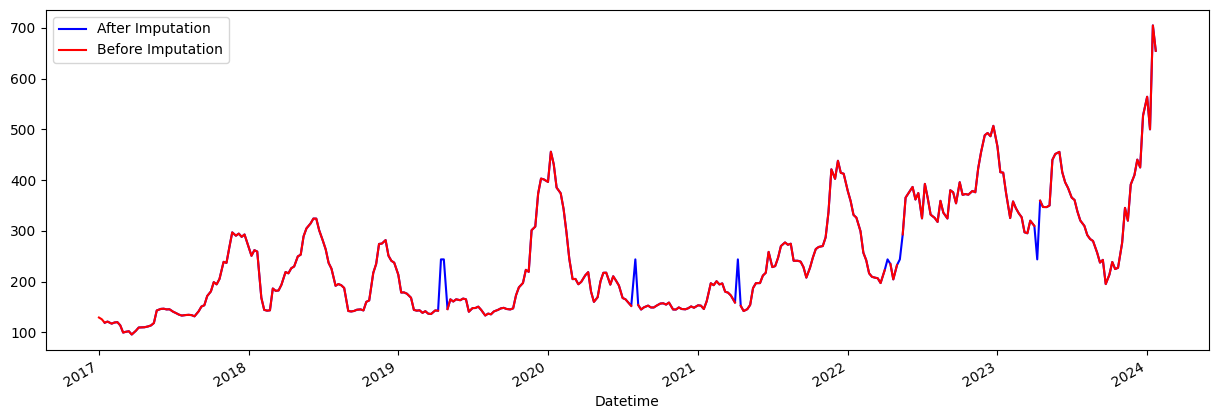

In [97]:
fix, ax = plt.subplots(1, 1, figsize=(15, 5))
df["Price"].plot(ax=ax, label="After Imputation", color="blue")
priceData[priceData["Name"] == vegetable]["Price"].plot(ax=ax, label="Before Imputation", color="red")
plt.legend(loc='upper left')

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 338 entries, 2017-01-15 to 2024-01-22
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               338 non-null    object 
 1   Price              338 non-null    float64
 2   Week               338 non-null    int64  
 3   Month              338 non-null    int64  
 4   Year               338 non-null    int64  
 5   Season             338 non-null    object 
 6   anuradhapura       338 non-null    float64
 7   jaffna             338 non-null    float64
 8   nuwaraeliya        338 non-null    float64
 9   Price_Lag          338 non-null    float64
 10  anuradhapura_Lag   338 non-null    float64
 11  jaffna_Lag         338 non-null    float64
 12  nuwaraeliya_Lag    338 non-null    float64
 13  Price_Mean         338 non-null    float64
 14  anuradhapura_Mean  338 non-null    float64
 15  jaffna_Mean        338 non-null    float64
 16  nuwarae

## Preprocess Data

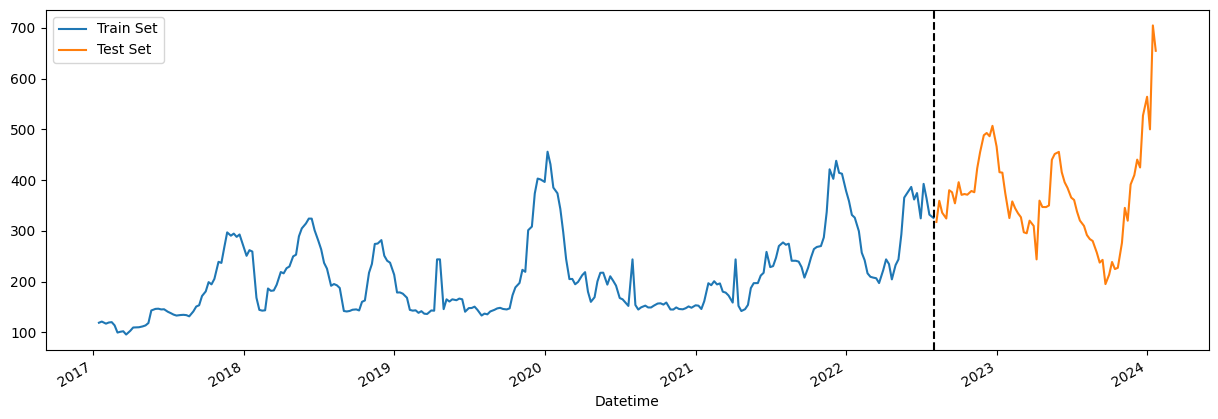

In [99]:
split_date = "2022-08-01"
train = df.loc[df.index <= split_date]
test = df.loc[df.index > split_date]
fix, ax = plt.subplots(1, 1, figsize=(15, 5))
train['Price'].plot(ax=ax, label="Train Set")
test['Price'].plot(ax=ax, label="Test Set")
ax.axvline(split_date, color="black", ls="--")
ax.legend("Training set", "Test Set")
plt.legend(loc='upper left')
plt.show()

In [100]:
# divide the dataset into features and target
FEATURES = ["Week", "Month", "Year",
            #"anuradhapura", "jaffna", "nuwaraeliya", 
            "Price_Lag", # "anuradhapura_Lag", "jaffna_Lag", "nuwaraeliya_Lag",
            "Price_Mean", # "anuradhapura_Mean", "jaffna_Mean", "nuwaraeliya_Mean"
        ]
TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

## Model Training

### XGB Regressor

In [101]:
XGB_reg = XGBRegressor(n_estimators=3000, learning_rate=0.001)
XGB_reg.fit(X_train, y_train, early_stopping_rounds=3000, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Random Forest Regressor

In [102]:
RF_reg = RandomForestRegressor(bootstrap=True, criterion='friedman_mse',max_depth=None, max_leaf_nodes=None,n_estimators=10000, random_state=None, n_jobs=15, verbose=False)
RF_reg.fit(X_train, y_train)

RandomForestRegressor(criterion='friedman_mse', n_estimators=10000, n_jobs=15,
                      verbose=False)

### Cat Boost Regressor

In [103]:
CB_reg =  CatBoostRegressor(iterations=50000, depth=5, learning_rate=0.001, loss_function='RMSE')
CB_reg.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

### Facebook Prophet

In [104]:
fb_prophet = Prophet()
fb_prophet.fit(train.reset_index().rename(columns={"Datetime": "ds", "Price": "y"}))

04:32:52 - cmdstanpy - INFO - Chain [1] start processing
04:32:52 - cmdstanpy - INFO - Chain [1] done processing


### ARIMA Model

In [105]:
train2 = train.copy()
train2.dropna(inplace=True)
# find the best model
stepwise_fit = auto_arima(df["Price"], exogenous=train2, trace=True, suppress_warnings=True, seasonal=True, m=12, stepwise=True, error_action="ignore",max_p=3, max_q=3, max_P=3, max_Q=3,)

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.08 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3251.439, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3241.524, Time=0.32 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3244.661, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3250.389, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3252.065, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3240.123, Time=0.71 sec
 ARIMA(1,1,0)(3,0,0)[12] intercept   : AIC=3241.983, Time=1.44 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3241.334, Time=1.99 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(1,1,0)(3,0,1)[12] intercept   : AIC=inf, Time=4.78 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=3241.947, Time=0.48 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=3241.549, Time=0.90 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=3242.003, Time=1.19 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=3240.532, Time=0.77 sec
 ARIMA(2,1

In [106]:
arima = SARIMAX(train2[TARGET],exog=train2[FEATURES], order=(stepwise_fit.get_params()["order"]),seasonal_order=(0, 0, 0, 0))
arima = arima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09228D+00    |proj g|=  6.18353D-03

At iterate    5    f=  4.09204D+00    |proj g|=  1.30076D-02

At iterate   10    f=  4.09130D+00    |proj g|=  9.75321D-04

At iterate   15    f=  4.09129D+00    |proj g|=  6.46484D-04

At iterate   20    f=  4.09129D+00    |proj g|=  7.38506D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     20     23      1     0     0   7.385D-05   4.091D+00
  F =   4.0912907293194190     

CONVERG

 This problem is unconstrained.


## Model Evaluation

### XGB Regressor

In [107]:
# Evaluate the model
y_pred = XGB_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
score = XGB_reg.score(X_test, y_test)
print("MSE: ", mse)
print("Score: ", score*100)

MSE:  4871.60266494874
Score:  45.78856913830306


### Random Forest Regressor

In [108]:
# Evaluate the model
y_pred = RF_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
score = RF_reg.score(X_test, y_test)
print("MSE: ", mse)
print("Score: ", score*100)

MSE:  3945.9273102576253
Score:  56.08952940591186


### Cat Boost Regressor

In [109]:
# Evaluate the model
y_pred = CB_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
score = CB_reg.score(X_test, y_test)
print("MSE: ", mse)
print("Score: ", score*100)

MSE:  4085.0976563172635
Score:  54.540835041386984


### Facebook Prophet

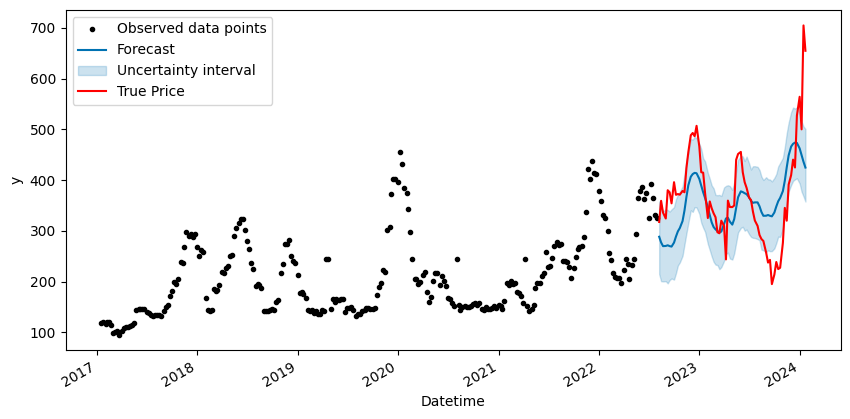

In [110]:
# Evaluate the model
forecast = fb_prophet.predict(test.reset_index().rename(columns={"Datetime": "ds", "Price": "y"}))
fix, ax = plt.subplots(figsize=(10, 5))
fig = fb_prophet.plot(forecast, ax=ax)
test["Price"].plot(ax=ax, label="True Price", color="r")
plt.legend(loc='upper left')
plt.show()

### ARIMA Model

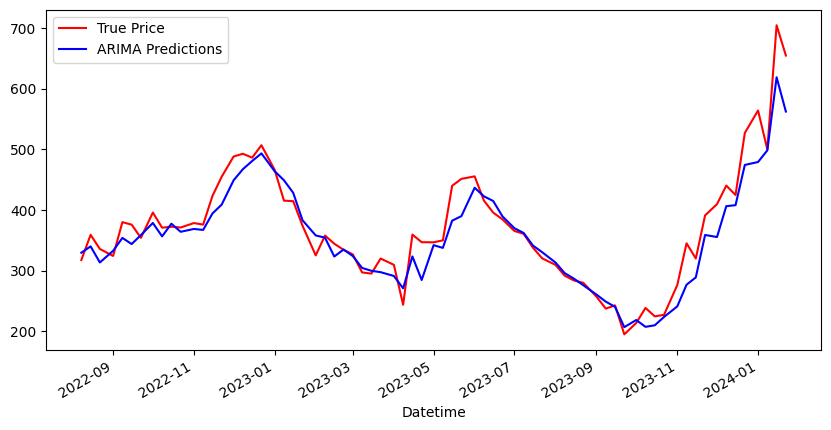

In [111]:
start = len(train2)
end = len(train2) + len(test) - 1
predictions = arima.predict(start=start, end=end, typ="levels", exog=test[FEATURES]).rename("ARIMA Predictions")
predictions.index = test.index
fix, ax = plt.subplots(figsize=(10, 5))
test["Price"].plot(ax=ax, label="True Price", color="r")
predictions.plot(ax=ax, label="ARIMA Predictions", color="b")
plt.legend(loc='upper left')
plt.show()

### All Model Evaluation

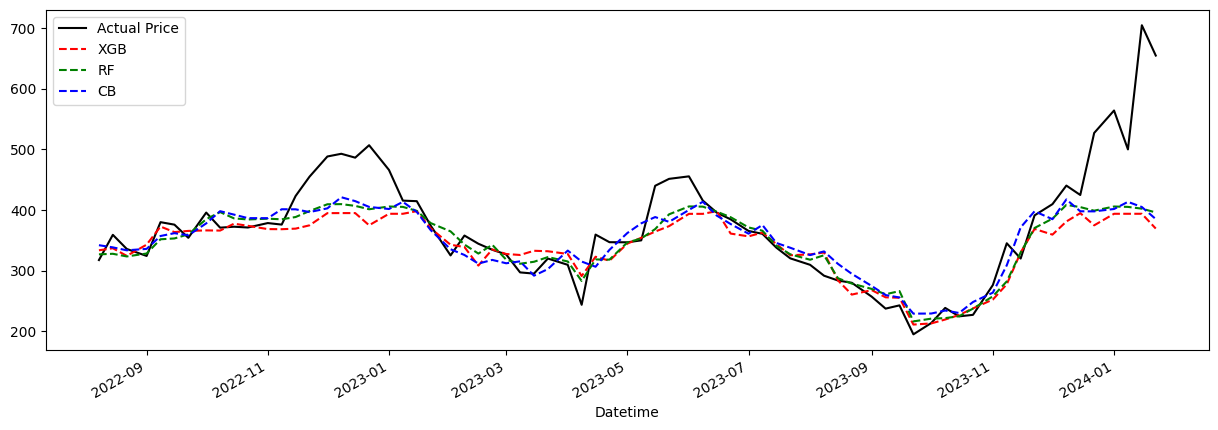

In [112]:
# Foreacast the price
prediction = test.copy()
prediction["XGB"] = XGB_reg.predict(X_test)
prediction["RF"] = RF_reg.predict(X_test)
prediction["CB"] = CB_reg.predict(X_test)
ax = prediction["Price"].plot(label="Actual Price", figsize=(15, 5), color="black")
prediction["XGB"].plot(ax=ax, label="XGB", color="red", style="--")
prediction["RF"].plot(ax=ax, label="RF", color="green", style="--")
prediction["CB"].plot(ax=ax, label="CB", color="blue", style="--")
plt.legend(loc='upper left')
plt.show()